In [1]:
import os
import numpy as np
# import efficientnet.tfkeras

from vit_keras import vit, utils
from tensorflow.keras.models import load_model
# validation
import pandas as pd

2023-03-16 13:58:28.554680: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-16 13:58:28.645932: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-03-16 13:58:29.048665: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/home/kannika/miniconda3/envs/vit-tf/lib/
2023-03-16 13:58:29.048714: W tensorflow/com

In [2]:
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   
os.environ["CUDA_VISIBLE_DEVICES"]="0"

In [3]:
import tensorflow as tf

physical_devices = tf.config.list_physical_devices('GPU') 
print("Num GPUs:", len(physical_devices))

Num GPUs: 1


## load model

> *500 Epoch*

In [4]:
#load model  #ValueError: Unknown layer: 'Custom>ClassToken'
from tensorflow.keras.models import load_model

model_dir = '/media/SSD/rheology2023/VitModel/Regression/tensorflow/Exp-3/R1/models/modelRegress_ViT_l32_Rheology_R1.h5'
model = load_model(model_dir)
height = width = model.input_shape[1]
# # model = tf.keras.models.load_model(
# #     model_dir,
# #     custom_objects={'Custom>ClassToken':tf.keras.models.Model, 'Custom>AddPositionEmbs':tf.keras.models.Model})
# # model.summary()
print(f"height: {height}, width: {width}")

2023-03-16 13:58:40.476920: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-16 13:58:40.946321: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1613] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 9431 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 2080 Ti, pci bus id: 0000:17:00.0, compute capability: 7.5


height: 224, width: 224


In [5]:
model.summary()

Model: "Vit_Regression"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 embedding (Conv2D)          (None, 7, 7, 1024)        3146752   
                                                                 
 reshape (Reshape)           (None, 49, 1024)          0         
                                                                 
 class_token (ClassToken)    (None, 50, 1024)          1024      
                                                                 
 Transformer/posembed_input   (None, 50, 1024)         51200     
 (AddPositionEmbs)                                               
                                                                 
 Transformer/encoderblock_0   ((None, 50, 1024),       12596224  
 (TransformerBlock)           (None, 16, None, None)

## Evaluation model

In [6]:
###** Test set

dataframe = pd.read_csv('/home/kannika/codes_AI/Rheology2023/MSDT_datatest.csv')
print(dataframe.shape)
dataframe.head(5)

(870, 8)


,Unnamed: 0,GLY,folderName,fileName,pathimg,idt,MSDT,subset
0,0,GLY10,GLY10P100_D0_30HZ_20XINF_UWELL_20221230_072204,GLY10P100_D0_30HZ_20XINF_UWELL_20221230_072204...,/media/SSD/rheology2023/Glycerol_FFT_test/GLY1...,158,5.63,test
1,1,GLY10,GLY10P100_D0_30HZ_20XINF_UWELL_20221230_072204,GLY10P100_D0_30HZ_20XINF_UWELL_20221230_072204...,/media/SSD/rheology2023/Glycerol_FFT_test/GLY1...,25,0.84,test
2,2,GLY10,GLY10P100_D0_30HZ_20XINF_UWELL_20221230_072204,GLY10P100_D0_30HZ_20XINF_UWELL_20221230_072204...,/media/SSD/rheology2023/Glycerol_FFT_test/GLY1...,7,0.25,test
3,3,GLY10,GLY10P100_D0_30HZ_20XINF_UWELL_20221230_072204,GLY10P100_D0_30HZ_20XINF_UWELL_20221230_072204...,/media/SSD/rheology2023/Glycerol_FFT_test/GLY1...,125,4.45,test
4,4,GLY10,GLY10P100_D0_30HZ_20XINF_UWELL_20221230_072204,GLY10P100_D0_30HZ_20XINF_UWELL_20221230_072204...,/media/SSD/rheology2023/Glycerol_FFT_test/GLY1...,19,0.63,test


In [7]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

BATCH_SIZE = 16
valid_datagen = ImageDataGenerator(rescale=1./255)

val_generator = valid_datagen.flow_from_dataframe(
                dataframe = dataframe,
                directory = None,
                x_col = 'pathimg',
                y_col = 'MSDT',
                target_size = (height, width),
                batch_size=BATCH_SIZE,
                color_mode= 'rgb',
                class_mode='raw')

Found 870 validated image filenames.


In [8]:
from tensorflow.keras.preprocessing import image

def predict_image(img_path):
    # Read the image and resize it
    img = image.load_img(img_path, target_size=(height, width))
    # Convert it to a Numpy array with target shape.
    x = image.img_to_array(img)
    # Reshape
    x = x.reshape((1,) + x.shape)
    x /= 255.
    result = model.predict([x])
    
    return result[0]

#Predict
pred_list = list()
#prob_list = list()
img_path=dataframe['pathimg'].tolist()
for i in range(0,len(img_path)):
    predict = predict_image(img_path[i])
    pred_list.append(predict[0])
    print(predict)

2023-03-16 14:01:48.237031: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:428] Loaded cuDNN version 8100
2023-03-16 14:01:48.684968: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-03-16 14:01:48.685971: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-03-16 14:01:48.686003: W tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:85] Couldn't get ptxas version string: INTERNAL: Couldn't invoke ptxas --version
2023-03-16 14:01:48.687041: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-03-16 14:01:48.687145: W tensorflow/compiler/xla/stream_executor/gpu/redzone_allocator.cc:318] INTERNAL: Failed to launch ptxas
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be only logged once.


1/1 [==============================] - 5s 5s/step
[8.262804]
1/1 [==============================] - 0s 66ms/step
[0.751345]
1/1 [==============================] - 0s 70ms/step
[0.29029953]
1/1 [==============================] - 0s 68ms/step
[6.737994]
1/1 [==============================] - 0s 84ms/step
[0.40860084]
1/1 [==============================] - 0s 71ms/step
[2.5248783]
1/1 [==============================] - 0s 76ms/step
[20.715298]
1/1 [==============================] - 0s 61ms/step
[36.44837]
1/1 [==============================] - 0s 87ms/step
[61.408432]
1/1 [==============================] - 0s 72ms/step
[0.26399043]
1/1 [==============================] - 0s 75ms/step
[22.817194]
1/1 [==============================] - 0s 66ms/step
[3.013109]
1/1 [==============================] - 0s 63ms/step
[12.737476]
1/1 [==============================] - 0s 62ms/step
[0.38015303]
1/1 [==============================] - 0s 81ms/step
[1.0791159]
1/1 [==============================] - 0s 6

1/1 [==============================] - 0s 70ms/step
[0.6024418]
1/1 [==============================] - 0s 73ms/step
[11.204053]
1/1 [==============================] - 0s 65ms/step
[1.0402266]
1/1 [==============================] - 0s 65ms/step
[8.353799]
1/1 [==============================] - 0s 85ms/step
[0.32987678]
1/1 [==============================] - 0s 72ms/step
[15.818296]
1/1 [==============================] - 0s 72ms/step
[4.7499285]
1/1 [==============================] - 0s 60ms/step
[17.334888]
1/1 [==============================] - 0s 66ms/step
[1.8019223]
1/1 [==============================] - 0s 69ms/step
[0.36732486]
1/1 [==============================] - 0s 70ms/step
[0.39685223]
1/1 [==============================] - 0s 63ms/step
[39.41768]
1/1 [==============================] - 0s 75ms/step
[0.29186895]
1/1 [==============================] - 0s 80ms/step
[0.38458976]
1/1 [==============================] - 0s 70ms/step
[0.22355989]
1/1 [==============================]

1/1 [==============================] - 0s 74ms/step
[1.3715825]
1/1 [==============================] - 0s 85ms/step
[6.77184]
1/1 [==============================] - 0s 66ms/step
[12.967111]
1/1 [==============================] - 0s 69ms/step
[0.11316971]
1/1 [==============================] - 0s 76ms/step
[0.5089512]
1/1 [==============================] - 0s 65ms/step
[0.82995766]
1/1 [==============================] - 0s 97ms/step
[4.2827373]
1/1 [==============================] - 0s 66ms/step
[0.17865552]
1/1 [==============================] - 0s 64ms/step
[2.3402047]
1/1 [==============================] - 0s 67ms/step
[0.61184806]
1/1 [==============================] - 0s 65ms/step
[0.10005677]
1/1 [==============================] - 0s 67ms/step
[46.255062]
1/1 [==============================] - 0s 66ms/step
[0.59059954]
1/1 [==============================] - 0s 61ms/step
[24.236864]
1/1 [==============================] - 0s 85ms/step
[0.82849866]
1/1 [==============================

1/1 [==============================] - 0s 59ms/step
[15.940095]
1/1 [==============================] - 0s 68ms/step
[7.956213]
1/1 [==============================] - 0s 68ms/step
[0.449357]
1/1 [==============================] - 0s 70ms/step
[14.009707]
1/1 [==============================] - 0s 75ms/step
[0.24092686]
1/1 [==============================] - 0s 66ms/step
[0.23090847]
1/1 [==============================] - 0s 80ms/step
[26.129057]
1/1 [==============================] - 0s 66ms/step
[9.368555]
1/1 [==============================] - 0s 65ms/step
[0.26722458]
1/1 [==============================] - 0s 62ms/step
[0.491506]
1/1 [==============================] - 0s 63ms/step
[0.24729916]
1/1 [==============================] - 0s 66ms/step
[1.0137365]
1/1 [==============================] - 0s 68ms/step
[0.2116288]
1/1 [==============================] - 0s 60ms/step
[19.061863]
1/1 [==============================] - 0s 62ms/step
[0.5560047]
1/1 [==============================] - 0

1/1 [==============================] - 0s 60ms/step
[2.1448972]
1/1 [==============================] - 0s 75ms/step
[0.1965581]
1/1 [==============================] - 0s 64ms/step
[0.21207003]
1/1 [==============================] - 0s 68ms/step
[0.19377401]
1/1 [==============================] - 0s 67ms/step
[1.9201654]
1/1 [==============================] - 0s 71ms/step
[11.69353]
1/1 [==============================] - 0s 68ms/step
[3.6466172]
1/1 [==============================] - 0s 67ms/step
[0.6759506]
1/1 [==============================] - 0s 69ms/step
[0.33632454]
1/1 [==============================] - 0s 65ms/step
[0.8025885]
1/1 [==============================] - 0s 63ms/step
[16.303255]
1/1 [==============================] - 0s 64ms/step
[0.47526664]
1/1 [==============================] - 0s 64ms/step
[0.40049043]
1/1 [==============================] - 0s 73ms/step
[0.21453056]
1/1 [==============================] - 0s 79ms/step
[1.4197894]
1/1 [==============================

1/1 [==============================] - 0s 85ms/step
[0.6230353]
1/1 [==============================] - 0s 70ms/step
[1.3126274]
1/1 [==============================] - 0s 88ms/step
[0.06638779]
1/1 [==============================] - 0s 71ms/step
[0.27332324]
1/1 [==============================] - 0s 69ms/step
[0.05149668]
1/1 [==============================] - 0s 69ms/step
[0.04051702]
1/1 [==============================] - 0s 69ms/step
[0.04846266]
1/1 [==============================] - 0s 76ms/step
[0.1906428]
1/1 [==============================] - 0s 64ms/step
[0.21435496]
1/1 [==============================] - 0s 61ms/step
[0.8841661]
1/1 [==============================] - 0s 64ms/step
[0.3202659]
1/1 [==============================] - 0s 64ms/step
[1.682074]
1/1 [==============================] - 0s 62ms/step
[1.8861054]
1/1 [==============================] - 0s 62ms/step
[7.689107]
1/1 [==============================] - 0s 72ms/step
[3.7323492]
1/1 [==============================]

1/1 [==============================] - 0s 73ms/step
[0.9250847]
1/1 [==============================] - 0s 63ms/step
[0.1102102]
1/1 [==============================] - 0s 64ms/step
[0.51099485]
1/1 [==============================] - 0s 64ms/step
[0.16453171]
1/1 [==============================] - 0s 69ms/step
[0.14019737]
1/1 [==============================] - 0s 60ms/step
[0.46456668]
1/1 [==============================] - 0s 86ms/step
[0.30263662]
1/1 [==============================] - 0s 68ms/step
[0.34684172]
1/1 [==============================] - 0s 60ms/step
[0.18031268]
1/1 [==============================] - 0s 67ms/step
[0.14252156]
1/1 [==============================] - 0s 68ms/step
[1.0239673]
1/1 [==============================] - 0s 68ms/step
[0.16304263]
1/1 [==============================] - 0s 68ms/step
[0.20232818]
1/1 [==============================] - 0s 81ms/step
[0.14527844]
1/1 [==============================] - 0s 80ms/step
[0.15364046]
1/1 [=======================

In [9]:
pred_list

[8.262804,
 0.751345,
 0.29029953,
 6.737994,
 0.40860084,
 2.5248783,
 20.715298,
 36.44837,
 61.408432,
 0.26399043,
 22.817194,
 3.013109,
 12.737476,
 0.38015303,
 1.0791159,
 0.2466894,
 34.720512,
 0.17179726,
 0.2910323,
 43.621017,
 13.473751,
 18.65202,
 0.60424864,
 0.36531752,
 29.009974,
 1.700981,
 1.3347081,
 5.5605826,
 0.27611467,
 17.438292,
 38.900066,
 2.7733223,
 2.0369573,
 0.11429416,
 0.14780729,
 14.488411,
 13.048964,
 6.3142447,
 40.125797,
 0.32332656,
 0.19452024,
 25.987991,
 2.5124729,
 0.0045988746,
 0.2336641,
 10.128818,
 0.7027959,
 0.17477204,
 48.995876,
 28.320831,
 0.13371877,
 60.50214,
 2.805507,
 0.1528287,
 0.5401528,
 0.24242266,
 7.3966517,
 0.05762234,
 0.33388296,
 0.76555926,
 5.740844,
 12.430749,
 40.381386,
 0.263992,
 32.03937,
 0.19830984,
 0.25771803,
 0.52239007,
 4.7855263,
 2.4410412,
 0.33759832,
 33.293564,
 0.2450383,
 15.568777,
 0.72072095,
 5.715326,
 0.32489368,
 1.46127,
 57.366165,
 27.011715,
 0.19054362,
 5.374836,
 20.

In [10]:
print(len(pred_list))

dataframe['pre_MSDT'] = pred_list
dataframe.head(3)

870


,Unnamed: 0,GLY,folderName,fileName,pathimg,idt,MSDT,subset,pre_MSDT
0,0,GLY10,GLY10P100_D0_30HZ_20XINF_UWELL_20221230_072204,GLY10P100_D0_30HZ_20XINF_UWELL_20221230_072204...,/media/SSD/rheology2023/Glycerol_FFT_test/GLY1...,158,5.63,test,8.262804
1,1,GLY10,GLY10P100_D0_30HZ_20XINF_UWELL_20221230_072204,GLY10P100_D0_30HZ_20XINF_UWELL_20221230_072204...,/media/SSD/rheology2023/Glycerol_FFT_test/GLY1...,25,0.84,test,0.751345
2,2,GLY10,GLY10P100_D0_30HZ_20XINF_UWELL_20221230_072204,GLY10P100_D0_30HZ_20XINF_UWELL_20221230_072204...,/media/SSD/rheology2023/Glycerol_FFT_test/GLY1...,7,0.25,test,0.290300


In [11]:
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error


y_test = dataframe['MSDT'].tolist()
# The mean squared error
print("Root Mean squared error: %.4f" % mean_squared_error(y_test, pred_list, squared=False))
print("Mean squared error: %.4f" % mean_squared_error(y_test, pred_list))
print("Mean absolute error: %.4f" % mean_absolute_error(y_test, pred_list))

# The coefficient of determination: 1 is perfect prediction
print("Coefficient of determination: %.4f" % r2_score(y_test, pred_list))

Root Mean squared error: 1.9334
Mean squared error: 3.7382
Mean absolute error: 0.9725
Coefficient of determination: 0.9521


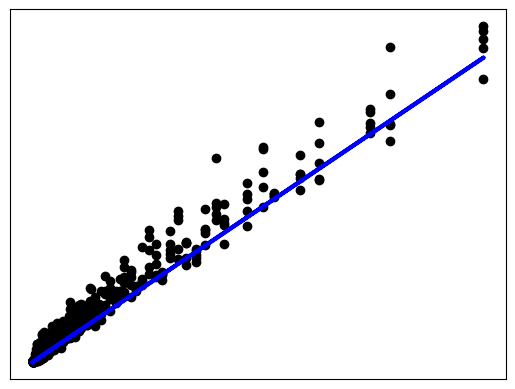

In [12]:
# Plot outputs
plt.scatter(y_test, pred_list, color="black")
plt.plot(y_test, y_test, color="blue", linewidth=3)

plt.xticks(())
plt.yticks(())

plt.show()

## Plot : GLY10

> ## t & msd unit

In [14]:
import random

## Set solution
G = 10
_G = f"GLY{G}"

df_idt = pd.read_csv(f'/home/kannika/codes_AI/Rheology2023/MSDT_G{G}.csv')
print(df_idt.shape)
_GLY = dataframe[dataframe['GLY']==_G]
setFolder = list(set(_GLY['folderName']))
rand = random.choices(setFolder, k=1)
rand_ = rand[0]
df_rand = _GLY[_GLY['folderName']==rand_].reset_index(drop=True)
print(df_rand.shape)
df_rand = df_rand.sort_values(by=['idt'])
list_t = df_idt['t'].tolist()
df_rand['t'] = list_t
df_rand.head(3)

(29, 3)
(29, 9)


,Unnamed: 0,GLY,folderName,fileName,pathimg,idt,MSDT,subset,pre_MSDT,t
25,112,GLY10,GLY10P100_D0_30HZ_20XINF_UWELL_20221229_193350,GLY10P100_D0_30HZ_20XINF_UWELL_20221229_193350...,/media/SSD/rheology2023/Glycerol_FFT_test/GLY1...,1,0.05,test,0.240392,0.052498
12,99,GLY10,GLY10P100_D0_30HZ_20XINF_UWELL_20221229_193350,GLY10P100_D0_30HZ_20XINF_UWELL_20221229_193350...,/media/SSD/rheology2023/Glycerol_FFT_test/GLY1...,2,0.09,test,0.169933,0.091199
4,91,GLY10,GLY10P100_D0_30HZ_20XINF_UWELL_20221229_193350,GLY10P100_D0_30HZ_20XINF_UWELL_20221229_193350...,/media/SSD/rheology2023/Glycerol_FFT_test/GLY1...,3,0.14,test,0.294169,0.140551


In [36]:
#df_rand['idt'].tolist()

In [15]:
#df_idt['dt'].tolist()
lstMSDT = df_rand['MSDT'].tolist() 
lstpre_MSDT = df_rand['pre_MSDT'].tolist() 
print(len(lstMSDT))
print(len(lstpre_MSDT))

29
29


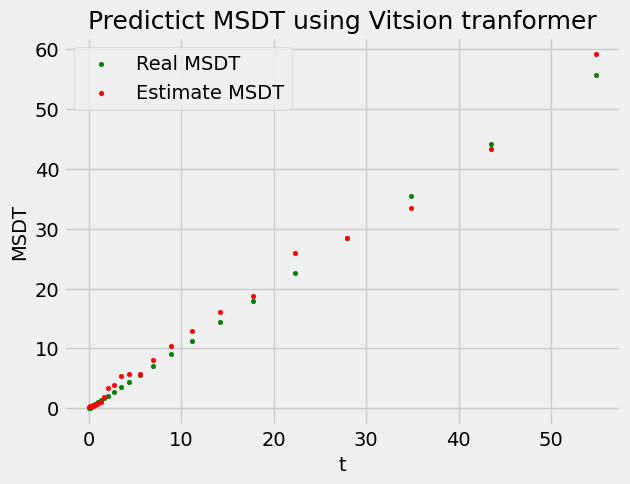

In [17]:
import matplotlib.pyplot as plt
## setting plot style
plt.style.use('fivethirtyeight')
  
## plotting residual errors in training data
plt.scatter(list_t, lstMSDT,
            color = "green", s = 10, label = 'Real MSDT')
## plotting residual errors in test data
plt.scatter(list_t, lstpre_MSDT,
            color = "red", s = 10, label = 'Estimate MSDT')
## plotting line for zero residual error
#plt.hlines(y = 0, xmin = 0, xmax = 50, linewidth = 2)
## plotting legend
plt.legend(loc = 'upper left')
## plot title
plt.title("Predictict MSDT using Vitsion tranformer", size=18)
plt.xlabel("t", size=14)
plt.ylabel("MSDT", size=14)
## method call for showing the plot
plt.show()

In [18]:
print(min(list_t))
print(max(list_t))

0.052498082
54.81658222


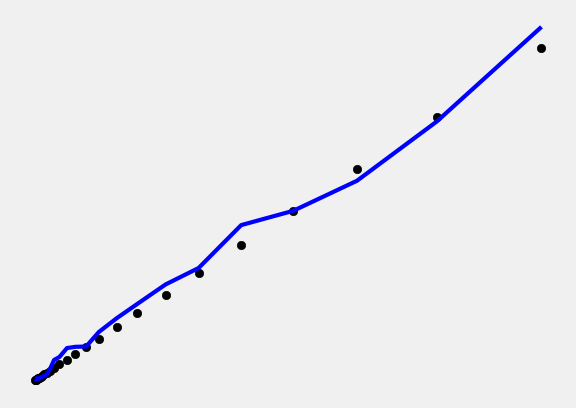

In [19]:
# Plot outputs
plt.scatter(list_t, lstMSDT, color="black")
plt.plot(list_t, lstpre_MSDT, color="blue", linewidth=3)

plt.xticks(())
plt.yticks(())

plt.show()

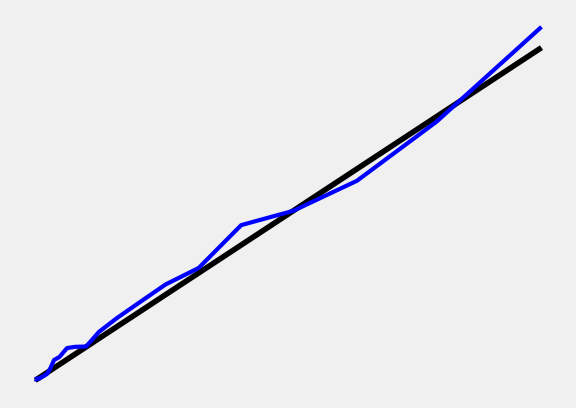

In [20]:
# Plot outputs
plt.plot(list_t, lstMSDT, color="black")
plt.plot(list_t, lstpre_MSDT, color="blue", linewidth=3)

plt.xticks(())
plt.yticks(())

plt.show()

---------------------------------